<a href="https://colab.research.google.com/github/antipovaya/probability-theory-and-mathematical-statistics/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%BD%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D1%85_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Модели регрессии на банковских данных**

1. Подготовка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Создадим синтетические банковские данные
np.random.seed(42)
n_customers = 1000

# Генерация данных
data = {
    'age': np.random.randint(18, 70, n_customers),
    'income': np.random.normal(50000, 20000, n_customers),
    'credit_score': np.random.normal(650, 100, n_customers),
    'loan_amount': np.random.normal(100000, 50000, n_customers),
    'employment_years': np.random.exponential(5, n_customers),
    'savings': np.random.exponential(20000, n_customers),
    'existing_loans': np.random.poisson(1, n_customers),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_customers),
    'marital_status': np.random.choice(['Single', 'Married', 'Divorced'], n_customers),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_customers)
}

df = pd.DataFrame(data)
df['income'] = np.abs(df['income'])  # Доход не может быть отрицательным
df['credit_score'] = np.clip(df['credit_score'], 300, 850)  # Кредитный скоринг в допустимых пределах
df['employment_years'] = np.clip(df['employment_years'], 0, 40)  # Опыт работы ограничен
df['savings'] = np.abs(df['savings'])

# Создаем целевую переменную - вероятность дефолта по кредиту
df['default_probability'] = (
    0.3 * (df['credit_score'] - 300) / 550 +  # влияние кредитного скоринга
    0.2 * (df['income'] - 20000) / 80000 +    # влияние дохода
    0.1 * (df['age'] - 18) / 52 -             # влияние возраста
    0.2 * df['savings'] / 50000 +             # влияние сбережений
    0.1 * np.random.normal(0, 0.1, n_customers)  # случайный шум
)

df['default'] = (df['default_probability'] > 0.5).astype(int)

print("Первые 5 строк данных:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")

Первые 5 строк данных:
   age        income  credit_score    loan_amount  employment_years  \
0   56  17871.073595    822.696385  199625.767658          2.684505   
1   69  54069.272717    610.036381   61667.170611          0.121489   
2   46  34872.985094    672.468473   72522.143205          2.042636   
3   32  21554.925808    743.259083  142979.394349          0.974495   
4   60  37068.542315    508.163427   80643.467511          0.518056   

        savings  existing_loans education marital_status region  \
0   8722.812307               1    Master        Married  North   
1   7585.225405               3       PhD       Divorced  South   
2  13506.921793               0    Master       Divorced  North   
3   7734.837213               0    Master       Divorced  South   
4   4270.249549               1       PhD         Single   East   

   default_probability  default  
0             0.298250        0  
1             0.324900        0  
2             0.225726        0  
3          

2. Линейная регрессия: прогнозирование кредитного скоринга

=== ЛИНЕЙНАЯ РЕГРЕССИЯ: Прогнозирование кредитного скоринга ===
Среднеквадратичная ошибка (MSE): 9260.26
Коэффициент детерминации (R²): 0.0052
Средний кредитный скоринг: 654.37


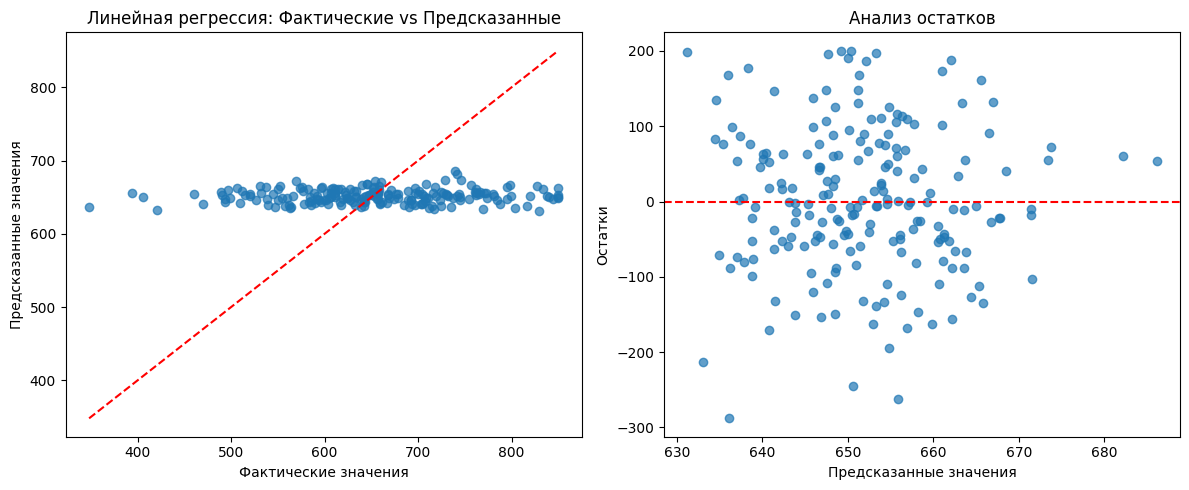


Важность признаков:
             Feature  Coefficient
2   employment_years     5.213121
6    marital_encoded    -4.802347
1             income    -3.834422
5  education_encoded    -2.859550
3            savings     2.792355
4     existing_loans     2.059446
0                age     2.042490
7     region_encoded     0.780090


In [2]:
# Подготовка данных для линейной регрессии
X_linear = df[['age', 'income', 'employment_years', 'savings', 'existing_loans']]
y_linear = df['credit_score']

# Кодируем категориальные переменные
le_education = LabelEncoder()
le_marital = LabelEncoder()
le_region = LabelEncoder()

X_linear['education_encoded'] = le_education.fit_transform(df['education'])
X_linear['marital_encoded'] = le_marital.fit_transform(df['marital_status'])
X_linear['region_encoded'] = le_region.fit_transform(df['region'])

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Прогнозирование
y_pred = lr_model.predict(X_test_scaled)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== ЛИНЕЙНАЯ РЕГРЕССИЯ: Прогнозирование кредитного скоринга ===")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.4f}")
print(f"Средний кредитный скоринг: {y_test.mean():.2f}")

# Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Линейная регрессия: Фактические vs Предсказанные')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')

plt.tight_layout()
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X_linear.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nВажность признаков:")
print(feature_importance)

3. Логистическая регрессия: прогнозирование дефолта по кредиту

=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ: Прогнозирование дефолта ===
Доля дефолтов в тестовой выборке: 0.000


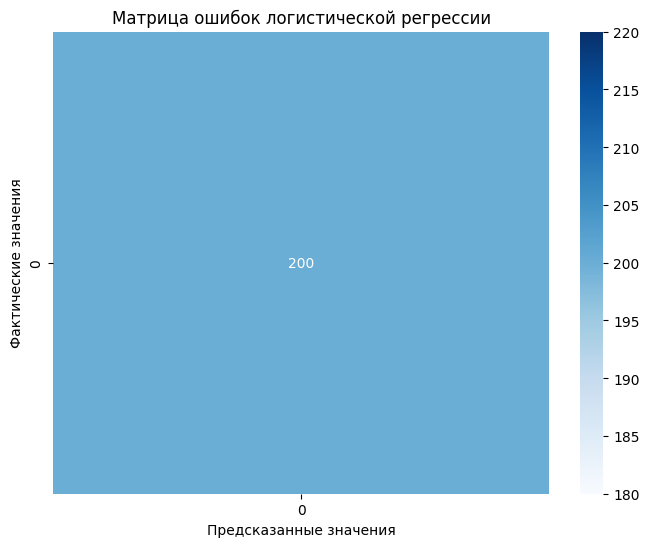


Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



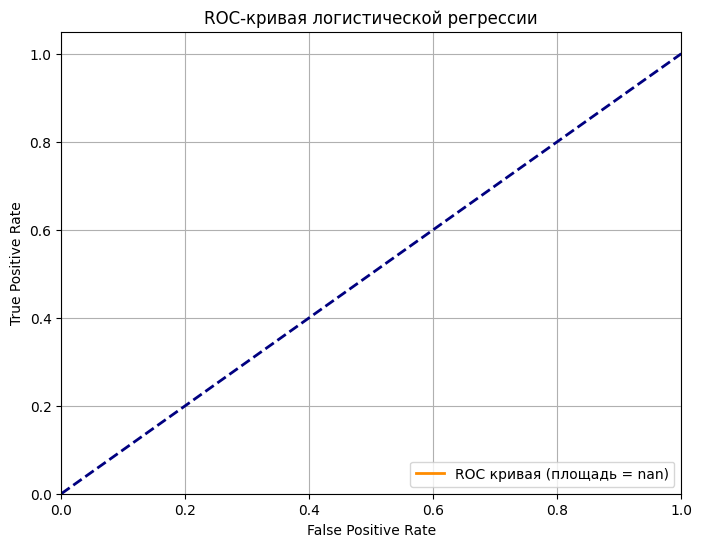


Важность признаков в логистической регрессии:
             Feature  Coefficient
1             income     1.470617
0                age     0.953950
2       credit_score     0.911056
4            savings    -0.796274
5     existing_loans    -0.496675
7    marital_encoded     0.443201
6  education_encoded    -0.389292
3   employment_years    -0.077550
8     region_encoded     0.027738


In [3]:
# Подготовка данных для логистической регрессии
X_logistic = df[['age', 'income', 'credit_score', 'employment_years', 'savings', 'existing_loans']]
y_logistic = df['default']

# Добавляем закодированные категориальные переменные
X_logistic['education_encoded'] = le_education.transform(df['education'])
X_logistic['marital_encoded'] = le_marital.transform(df['marital_status'])
X_logistic['region_encoded'] = le_region.transform(df['region'])

# Разделяем данные
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_logistic, y_logistic, test_size=0.2, random_state=42, stratify=y_logistic
)

# Масштабирование
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

# Обучение логистической регрессии
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_log_scaled, y_train_log)

# Прогнозирование вероятностей
y_pred_proba = logistic_model.predict_proba(X_test_log_scaled)[:, 1]
y_pred_class = logistic_model.predict(X_test_log_scaled)

print("=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ: Прогнозирование дефолта ===")
print(f"Доля дефолтов в тестовой выборке: {y_test_log.mean():.3f}")

# Матрица ошибок
cm = confusion_matrix(y_test_log, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок логистической регрессии')
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.show()

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test_log, y_pred_class))

# ROC-кривая
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_log, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (площадь = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Важность признаков в логистической регрессии
logistic_importance = pd.DataFrame({
    'Feature': X_logistic.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nВажность признаков в логистической регрессии:")
print(logistic_importance)

4. Регуляризованные регрессии: Ridge и Lasso

=== СРАВНЕНИЕ РЕГРЕССИОННЫХ МОДЕЛЕЙ ===
Linear Regression: MSE = 9260.26
Ridge Regression: MSE = 9260.21
Lasso Regression: MSE = 9258.55


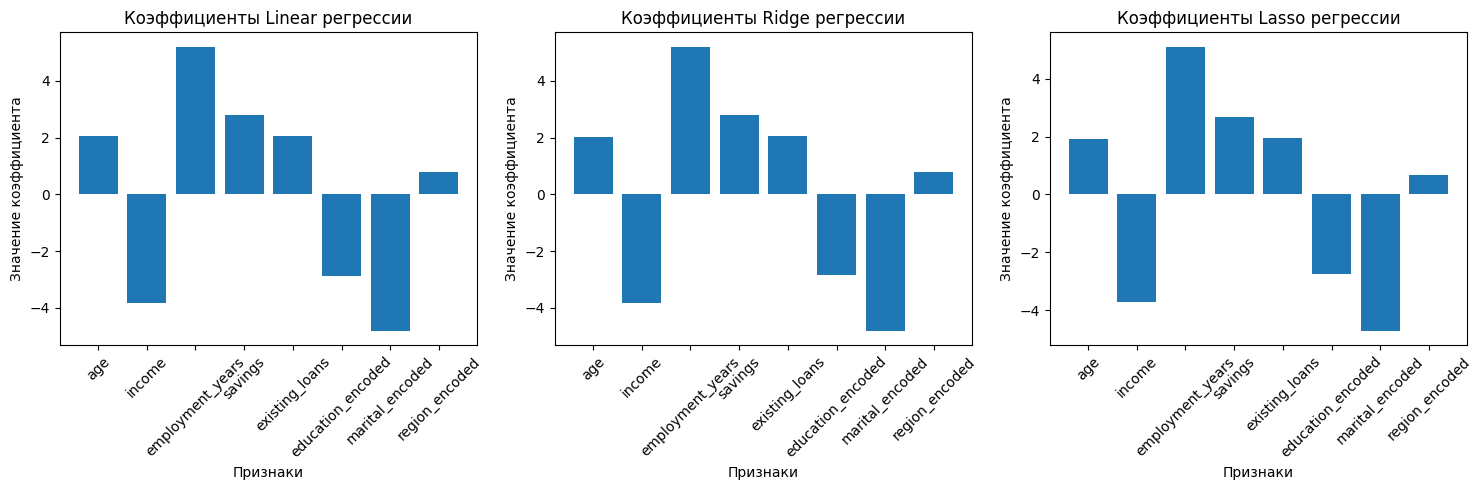

In [4]:
# Ridge регрессия (L2 регуляризация)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Lasso регрессия (L1 регуляризация)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Сравнение моделей
models_comparison = {
    'Linear Regression': mean_squared_error(y_test, y_pred),
    'Ridge Regression': mean_squared_error(y_test, y_pred_ridge),
    'Lasso Regression': mean_squared_error(y_test, y_pred_lasso)
}

print("=== СРАВНЕНИЕ РЕГРЕССИОННЫХ МОДЕЛЕЙ ===")
for model_name, mse_value in models_comparison.items():
    print(f"{model_name}: MSE = {mse_value:.2f}")

# Визуализация коэффициентов
plt.figure(figsize=(15, 5))

models = [lr_model, ridge_model, lasso_model]
model_names = ['Linear', 'Ridge', 'Lasso']

for i, (model, name) in enumerate(zip(models, model_names)):
    plt.subplot(1, 3, i+1)
    coefficients = model.coef_
    plt.bar(range(len(coefficients)), coefficients)
    plt.title(f'Коэффициенты {name} регрессии')
    plt.xlabel('Признаки')
    plt.ylabel('Значение коэффициента')
    plt.xticks(range(len(coefficients)), X_linear.columns, rotation=45)

plt.tight_layout()
plt.show()

5. Ансамблевые методы: Случайный лес и Градиентный бустинг

In [5]:
# Случайный лес для регрессии
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Градиентный бустинг для регрессии
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Сравнение всех моделей
all_models_comparison = {
    'Linear Regression': r2_score(y_test, y_pred),
    'Ridge Regression': r2_score(y_test, y_pred_ridge),
    'Lasso Regression': r2_score(y_test, y_pred_lasso),
    'Random Forest': r2_score(y_test, y_pred_rf),
    'Gradient Boosting': r2_score(y_test, y_pred_gb)
}

print("=== СРАВНЕНИЕ R² ВСЕХ МОДЕЛЕЙ ===")
for model_name, r2_value in all_models_comparison.items():
    print(f"{model_name}: R² = {r2_value:.4f}")

# Важность признаков в случайном лесе
rf_importance = pd.DataFrame({
    'Feature': X_linear.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nВажность признаков в случайном лесе:")
print(rf_importance)

# Кросс-валидация
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

print(f"\nКросс-валидация R² (линейная регрессия): {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Кросс-валидация R² (случайный лес): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

=== СРАВНЕНИЕ R² ВСЕХ МОДЕЛЕЙ ===
Linear Regression: R² = 0.0052
Ridge Regression: R² = 0.0052
Lasso Regression: R² = 0.0053
Random Forest: R² = 0.0121
Gradient Boosting: R² = -0.0229

Важность признаков в случайном лесе:
             Feature  Importance
2   employment_years    0.237617
3            savings    0.198429
1             income    0.194011
0                age    0.165101
7     region_encoded    0.057432
5  education_encoded    0.056396
4     existing_loans    0.052398
6    marital_encoded    0.038616

Кросс-валидация R² (линейная регрессия): -0.0099 ± 0.0083
Кросс-валидация R² (случайный лес): 0.0014 ± 0.0433


6. Прогнозирование для новых клиентов